# **SPEECH EMOTION RECOGNITION**


**TABLE OF CONTENTS**
* INTRODUCTION
* EXPLORATORY DATA ANALYSIS (EDA)
* DATA AUGMENTATION
* FEATURE EXTRACTION
* MODEL

# INTRODUCTION

**PROBLEM STATEMENT**

The purpose is to recognize the emotion and affective state of the speaker from his/her speech signal. 

**DATA SOURCE USED**

We have used the RAVDESS dataset in this project.It is one of the more common dataset used for this excercise by others. It's well liked because of its quality of speakers, recording and it has 24 actors of different genders.
Here's the filename identifiers as per the official RAVDESS website:

* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Here's an example of an audio filename. 02-01-06-01-02-01-12.mp4

# EXPLORATORY DATA ANALYSIS

The key features of the audio data are namely, MFCC (Mel Frequency Cepstral Coefficients) and Mel Spectrogram 

* MFCC (Mel Frequency Cepstral Coefficients)- 
MFCC is important feature extraction when using speech data,Mel scale is a scale that relates the perceived frequency of a tone to the real measured frequency. It scales the frequency so that you can fit greater carefully what the human ear can hear 



* Mel Spectrogram- 
A Fast Fourier Transform is computed on overlapping windowed segments of the signal, and what is the spectrogram , Spectrogram is visual way of representation of signal strength and also use for display the frequency sound waves.



For the EDA we have used MFCC and Mel Spectogram

In [2]:
#IMPORT THE LIBRARIES
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
import IPython.display as ipd
from IPython.display import Audio
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM,BatchNormalization , GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import SGD



import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
# path to the directory
RAVD = "/kaggle/input/ravdess-emotional-speech-audio/audio_speech_actors_01-24/"

In [4]:
dirl_list = os.listdir(RAVD)
dirl_list.sort()

emotion = []
gender = []
path = []
for i in dirl_list:
    fname = os.listdir(RAVD + i)
    for f in fname:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVD + i + '/' + f)

        
RAVD_df = pd.DataFrame(emotion)
RAVD_df = RAVD_df.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVD_df = pd.concat([pd.DataFrame(gender),RAVD_df],axis=1)
RAVD_df.columns = ['gender','emotion']
RAVD_df['labels'] =RAVD_df.gender + '_' + RAVD_df.emotion
RAVD_df['source'] = 'RAVDESS'  
RAVD_df = pd.concat([RAVD_df,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVD_df = RAVD_df.drop(['gender', 'emotion'], axis=1)
RAVD_df.labels.value_counts()

male_neutral       144
female_neutral     144
male_sad            96
male_fear           96
male_happy          96
male_disgust        96
male_angry          96
male_surprise       96
female_surprise     96
female_disgust      96
female_fear         96
female_sad          96
female_happy        96
female_angry        96
Name: labels, dtype: int64

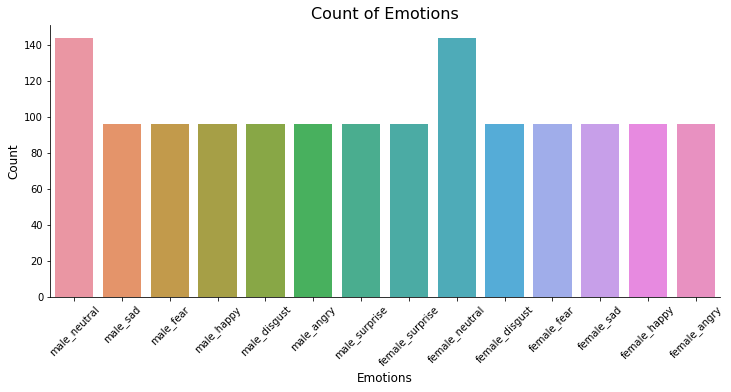

In [5]:
plt.figure(figsize=(12, 5))
plt.title('Count of Emotions', size=16)
sns.countplot(RAVD_df.labels)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
plt.xticks(rotation=45)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [6]:
# Female Happy
fRA1= RAVD + 'Actor_08/03-01-03-02-02-01-08.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1) 


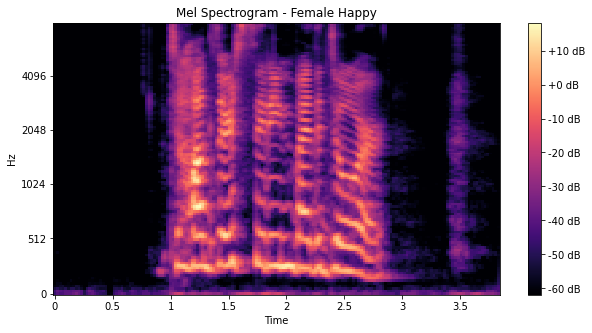

In [7]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Happy')
plt.colorbar(format='%+2.0f dB')

In [8]:
#Female Fear
fRA2=RAVD +'Actor_08/03-01-06-01-01-01-08.wav'
data, sr = librosa.load(fRA2)
ipd.Audio(fRA2) 

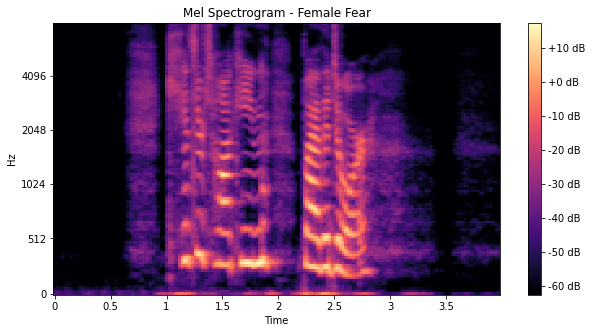

In [9]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Fear')
plt.colorbar(format='%+2.0f dB');

Next, we compare the waveplots of happy and fearful tracks

In [10]:
# Female Disgust
fRA1 =RAVD +'Actor_20/03-01-08-02-02-02-20.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1) 

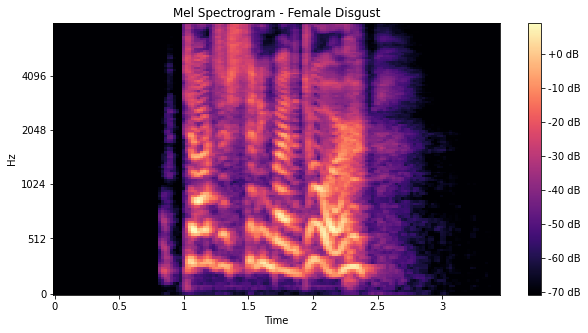

In [11]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Female Disgust')
plt.colorbar(format='%+2.0f dB');

In [12]:
# Male Fearfull
fRA1 = RAVD + 'Actor_19/03-01-04-01-02-01-19.wav'
data, sr = librosa.load(fRA1)
ipd.Audio(fRA1) 

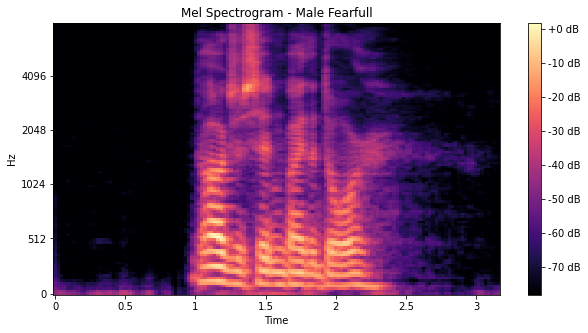

In [13]:
# CREATE LOG MEL SPECTROGRAM
plt.figure(figsize=(10, 5))
spectrogram = librosa.feature.melspectrogram(y=data, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)
librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Fearfull')
plt.colorbar(format='%+2.0f dB');

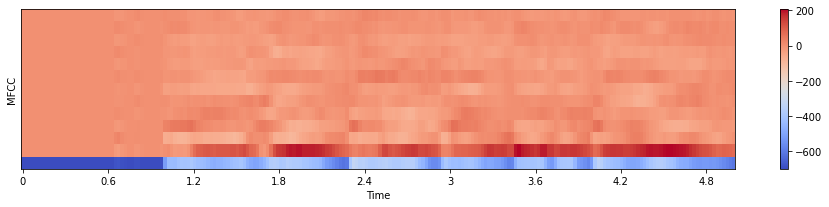

In [14]:
# Gender - Female; Emotion - Angry 
path = "../input/ravdess-emotional-speech-audio/Actor_18/03-01-05-01-01-01-18.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

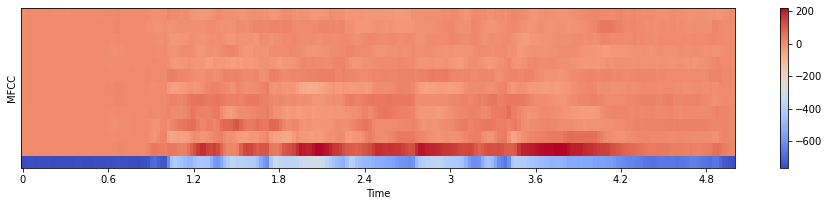

In [15]:
# Gender - Male; Emotion - Angry 
path = "../input/ravdess-emotional-speech-audio/Actor_17/03-01-05-01-01-02-17.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
mfcc = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)


# MFCC
plt.figure(figsize=(16, 10))
plt.subplot(3,1,1)
librosa.display.specshow(mfcc, x_axis='time')
plt.ylabel('MFCC')
plt.colorbar()

ipd.Audio(path)

216
216


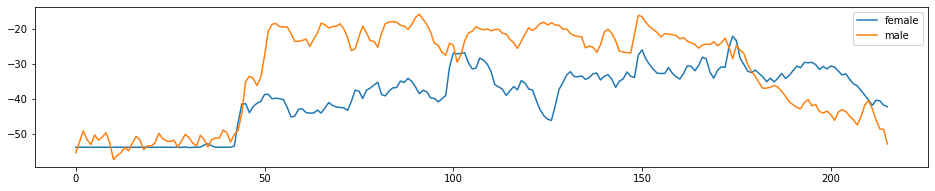

In [16]:
# Gender - Female; Emotion - angry
path = "../input/ravdess-emotional-speech-audio/Actor_18/03-01-05-01-01-01-18.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Gender - Male; Emotion - angry
path = "../input/ravdess-emotional-speech-audio/Actor_17/03-01-05-01-01-02-17.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

216
216


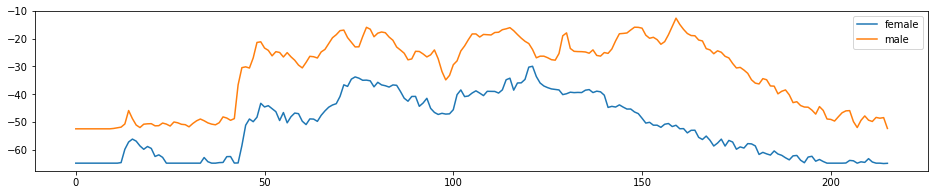

In [17]:
# Gender - Female; Emotion - Surprised
path = "../input/ravdess-emotional-speech-audio/Actor_20/03-01-08-02-01-02-20.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Gender - Male; Emotion - Surprised
path = "../input/ravdess-emotional-speech-audio/Actor_21/03-01-08-02-01-01-21.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(16,10))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

**Again we combine the emotion of suprised male female then again male has higher pitch**

# DATA AUGMENTATION

* Data augmentation is the process by which we create new polymerized data samples by adding small disturbance on our initial training set.
* To generate polymerized data for audio, we can apply noise injection, shifting time, changing pitch and speed.
* The objective is to make our model invariant to those disturbance and enhace its ability to generalize.
In order to this to work adding the disturbance must conserve the same label as the original training sample.

In [18]:
# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [19]:
# Trying different functions above
path = np.array(RAVD_df['path'])[471]
data, sample_rate = librosa.load(path)

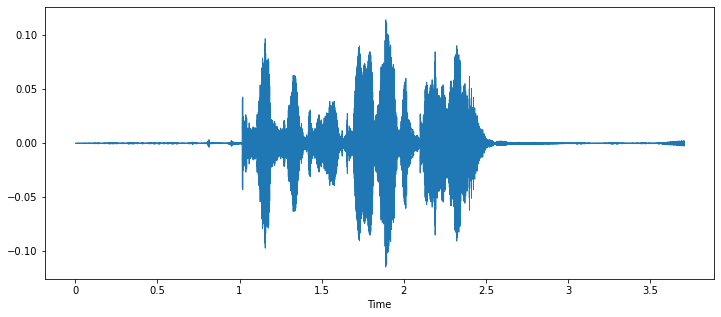

In [20]:
# NORMAL AUDIO


import librosa.display
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)

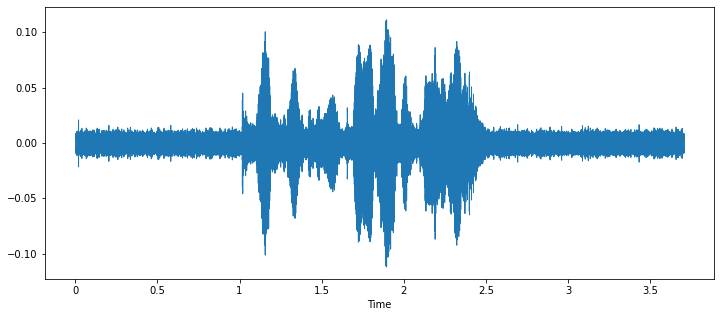

In [21]:
# AUDIO WITH NOISE
x = noise(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

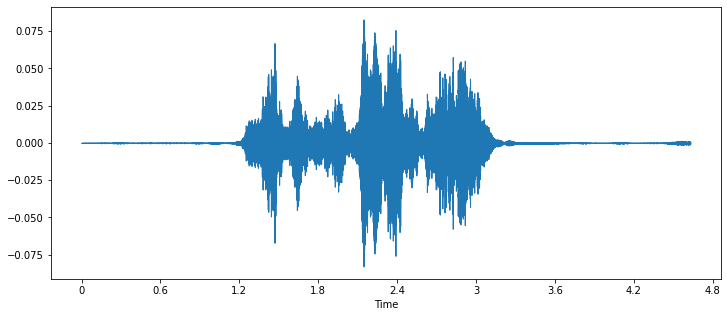

In [22]:
# STRETCHED AUDIO
x = stretch(data)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

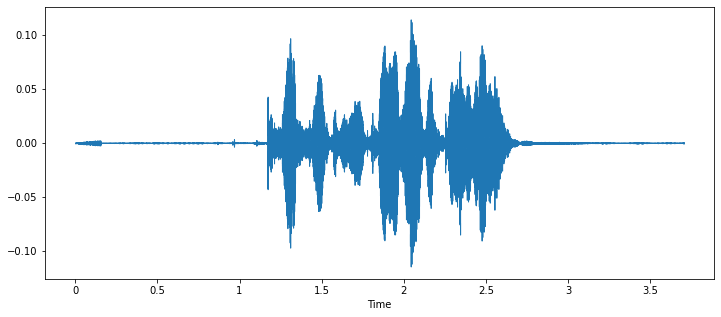

In [23]:
# SHIFTED AUDIO
x = shift(data)
plt.figure(figsize=(12,5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

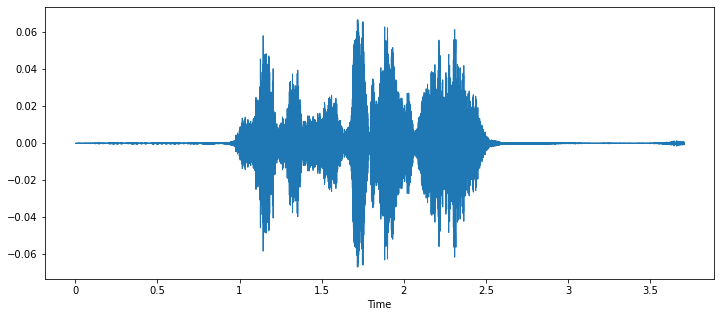

In [24]:
# AUDIO WITH PITCH
x = pitch(data, sample_rate)
plt.figure(figsize=(12, 5))
librosa.display.waveshow(y=x, sr=sample_rate)
Audio(x, rate=sample_rate)

**After listening to all audio we determine to use noise, shift and stretch**

# FEATURE EXTRACTION

In [25]:

def feat_ext(data):
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    return mfcc

def get_feat(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    # normal data
    res1 = feat_ext(data)
    result = np.array(res1)
    #data with noise
    noise_data = noise(data)
    res2 = feat_ext(noise_data)
    result = np.vstack((result, res2))
    #data with stretch and pitch
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = feat_ext(data_stretch_pitch)
    result = np.vstack((result, res3))
    return result

In [26]:
RAVD_df.head()

labels   source                                               path
0  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
1  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
2      male_sad  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
3  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...
4  male_neutral  RAVDESS  /kaggle/input/ravdess-emotional-speech-audio/a...

In [27]:
X, Y = [], []
for path, emotion in zip(RAVD_df['path'], RAVD_df['labels']):
    feature = get_feat(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [28]:
Emotions = pd.DataFrame(X)
Emotions['labels'] = Y
Emotions.to_csv('emotion.csv', index=False)
Emotions.head()

0          1          2          3          4         5         6  \
0 -626.266724  93.891739  -0.696724  17.828402   9.496765  2.025836 -2.726057   
1 -473.864277  45.749487  11.234232  10.678440   5.309569  1.929831 -2.456593   
2 -680.248840  90.475075  -2.995894  17.773800   6.314990  0.721864 -6.446220   
3 -634.959839  72.811478  -3.487027  20.697269  10.188320 -0.667840 -3.293633   
4 -400.236340  21.602361   8.947922   9.102155   4.769711  0.346699 -1.830401   

           7          8         9  ...        11        12        13  \
0  -8.519138 -12.432029 -6.580182  ... -2.754473  0.774303 -5.368925   
1  -8.369898  -9.630987 -5.990256  ... -0.446248 -0.754346 -2.810756   
2 -11.473070 -14.421736 -4.904967  ... -1.993777 -0.631423 -6.631641   
3  -7.447817 -16.703850 -2.161060  ... -3.714514  0.273591 -4.517450   
4  -5.517206  -7.114449 -3.983076  ... -1.206845 -2.047372 -1.832547   

         14        15        16        17        18        19        labels  
0 -0.340401  1.479823 -8.706111 -2.767465 -1.620493 -1.525633  male_neutral  
1 -0.673563  0.420669 -4.961863 -3.578336  0.271208 -3.004968  male_neutral  
2  1.132648 -2.568438 -8.887465 -1.244092 -2.682003 -6.089026  male_neutral  
3 -1.117245  0.534381 -6.885534 -1.295200 -3.289555  0.756877  male_neutral  
4 -0.542748 -0.478257 -2.998189 -2.092153 -0.131246 -0.968329  male_neutral  

[5 rows x 21 columns]

In [29]:
# can use this directly from saved feature .csv file
Emotions = pd.read_csv('./emotion.csv')
Emotions.head()

0          1          2          3          4         5         6  \
0 -626.266724  93.891739  -0.696724  17.828402   9.496765  2.025836 -2.726057   
1 -473.864277  45.749487  11.234232  10.678440   5.309569  1.929831 -2.456593   
2 -680.248840  90.475075  -2.995894  17.773800   6.314990  0.721864 -6.446220   
3 -634.959839  72.811478  -3.487027  20.697269  10.188320 -0.667840 -3.293633   
4 -400.236340  21.602361   8.947922   9.102155   4.769711  0.346699 -1.830401   

           7          8         9  ...        11        12        13  \
0  -8.519138 -12.432029 -6.580182  ... -2.754473  0.774303 -5.368925   
1  -8.369898  -9.630987 -5.990256  ... -0.446248 -0.754346 -2.810756   
2 -11.473070 -14.421736 -4.904967  ... -1.993777 -0.631423 -6.631641   
3  -7.447817 -16.703850 -2.161060  ... -3.714514  0.273591 -4.517450   
4  -5.517206  -7.114449 -3.983076  ... -1.206845 -2.047372 -1.832547   

         14        15        16        17        18        19        labels  
0 -0.340401  1.479823 -8.706111 -2.767465 -1.620493 -1.525633  male_neutral  
1 -0.673563  0.420669 -4.961863 -3.578336  0.271208 -3.004968  male_neutral  
2  1.132648 -2.568438 -8.887465 -1.244092 -2.682003 -6.089026  male_neutral  
3 -1.117245  0.534381 -6.885534 -1.295200 -3.289555  0.756877  male_neutral  
4 -0.542748 -0.478257 -2.998189 -2.092153 -0.131246 -0.968329  male_neutral  

[5 rows x 21 columns]

# DATA PREPROCESSING

In [30]:
X = Emotions.iloc[: ,:-1].values
Y = Emotions['labels'].values

In [31]:
# As this is a multiclass classification problem onehotencoding our Y
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [32]:
# Train and Test Split 
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 14), (1080, 20), (1080, 14))

In [33]:
# Reshape for LSTM 
X_train = x_train.reshape(x_train.shape[0] , x_train.shape[1] , 1)
X_test = x_test.reshape(x_test.shape[0] , x_test.shape[1] , 1)


In [34]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 20), (3240, 14), (1080, 20), (1080, 14))

# IMPLOYING MODELS

# Decision Tree

In [35]:
from sklearn.tree import DecisionTreeClassifier
clf3 = DecisionTreeClassifier()

clf3 = clf3.fit(x_train,y_train)

y_pred = clf3.predict(x_test)

In [36]:
print("Training set score: {:.3f}".format(clf3.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf3.score(x_test, y_test)))

Training set score: 1.000
Test set score: 0.430


**After Using the decision tree model in our dataset then the model goes in overfitting he gave accuracy around .41**

## **KNN**

In [37]:
from sklearn.neighbors import KNeighborsClassifier
clf1=KNeighborsClassifier(n_neighbors=4)
clf1.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=4)

In [38]:
y_pred=clf1.predict(x_test)

In [39]:
print("Training set score: {:.3f}".format(clf1.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf1.score(x_test, y_test)))

Training set score: 0.648
Test set score: 0.510


**Using KNN in our dataset the overall training is quite good but not for deployment and test accuracy has .50**

## **MLP CLASSIFIER**

In [40]:
from sklearn.neural_network import MLPClassifier
clf2=MLPClassifier(alpha=0.01, batch_size=270, epsilon=1e-08, hidden_layer_sizes=(400,), learning_rate='adaptive', max_iter=400)
clf2.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=270, hidden_layer_sizes=(400,),
              learning_rate='adaptive', max_iter=400)

In [41]:
print("Training set score: {:.3f}".format(clf2.score(x_train, y_train)))
print("Test set score: {:.3f}".format(clf2.score(x_test, y_test)))

Training set score: 0.950
Test set score: 0.670


**Using MLP Classifier he gave good accuracy in training dataset but not good for our test set, So we did not use for deployment.** 

# GRU

In [42]:
model03 = Sequential()
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
model03.add(Dropout(0.3))
model03.add(GRU(units=50, activation='tanh'))
model03.add(Dropout(0.3))
model03.add(Dense(units=14))
model03.compile(optimizer=SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),loss='mean_squared_error',metrics=['accuracy'])




2022-04-04 11:37:45.300500: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 11:37:45.428272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 11:37:45.429470: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-04 11:37:45.431744: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [43]:
model03.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 20, 50)            7950      
_________________________________________________________________
dropout (Dropout)            (None, 20, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 20, 50)            15300     
_________________________________________________________________
dropout_1 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
gru_2 (GRU)                  (None, 20, 50)            15300     
_________________________________________________________________
dropout_2 (Dropout)          (None, 20, 50)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 50)                1

In [44]:
model03.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=200)

Epoch 1/100


2022-04-04 11:37:49.172310: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-04-04 11:37:55.763979: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


17/17 [==============================] - 10s 110ms/step - loss: 0.0865 - accuracy: 0.0815 - val_loss: 0.0696 - val_accuracy: 0.0676
Epoch 2/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0769 - accuracy: 0.0852 - val_loss: 0.0666 - val_accuracy: 0.1148
Epoch 3/100
17/17 [==============================] - 0s 16ms/step - loss: 0.0733 - accuracy: 0.0907 - val_loss: 0.0659 - val_accuracy: 0.1880
Epoch 4/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0717 - accuracy: 0.1130 - val_loss: 0.0656 - val_accuracy: 0.1824
Epoch 5/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0712 - accuracy: 0.1040 - val_loss: 0.0654 - val_accuracy: 0.1926
Epoch 6/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0705 - accuracy: 0.1096 - val_loss: 0.0651 - val_accuracy: 0.1880
Epoch 7/100
17/17 [==============================] - 0s 14ms/step - loss: 0.0701 - accuracy: 0.1120 - val_loss: 0.0650 - val_accuracy: 0.1963
Epoch 8/100
17/1

In [45]:
print("Accuracy of our model on test data : " , model03.evaluate(X_test,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 5ms/step - loss: 0.0630 - accuracy: 0.2380
Accuracy of our model on test data :  23.79629611968994 %


**GRU(Gated Recurrent Unit) is important when we use speech dataset but in this model, we don't have good accuracy in training as well as testing so we do not take for further deployment.**

# LSTM

In [46]:
model01=Sequential()
model01.add(LSTM(70,return_sequences=True,input_shape=(20,1)))
model01.add(LSTM(50,return_sequences=True))
model01.add(LSTM(60))
model01.add(Dense(14))
model01.compile(loss='mean_squared_error',optimizer='adam',metrics=['accuracy'])


In [47]:
model01.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 70)            20160     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 50)            24200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                26640     
_________________________________________________________________
dense_1 (Dense)              (None, 14)                854       
Total params: 71,854
Trainable params: 71,854
Non-trainable params: 0
_________________________________________________________________


In [48]:
 model01.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=65,verbose=1)

Epoch 1/100
50/50 [==============================] - 6s 32ms/step - loss: 0.0640 - accuracy: 0.2019 - val_loss: 0.0613 - val_accuracy: 0.2620
Epoch 2/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0611 - accuracy: 0.2614 - val_loss: 0.0600 - val_accuracy: 0.2796
Epoch 3/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0603 - accuracy: 0.2870 - val_loss: 0.0597 - val_accuracy: 0.2833
Epoch 4/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0596 - accuracy: 0.2910 - val_loss: 0.0586 - val_accuracy: 0.3009
Epoch 5/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0593 - accuracy: 0.2972 - val_loss: 0.0581 - val_accuracy: 0.3167
Epoch 6/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0584 - accuracy: 0.3133 - val_loss: 0.0573 - val_accuracy: 0.3287
Epoch 7/100
50/50 [==============================] - 1s 11ms/step - loss: 0.0577 - accuracy: 0.3296 - val_loss: 0.0568 - val_accuracy: 0.3148
Epoch 

In [49]:
print("Accuracy of our model on test data : " , model01.evaluate(X_test,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 5ms/step - loss: 0.0376 - accuracy: 0.6731
Accuracy of our model on test data :  67.31481552124023 %


**So, After all, the model ran we use LSTM is important when using sequence data like speech, So using this it ran good on train set but in the test has not good.**

## **CNN**

In [50]:
#CNN
x_traincnn =np.expand_dims(x_train, axis=2)
x_testcnn= np.expand_dims(x_test, axis=2)
x_traincnn.shape, y_train.shape, x_testcnn.shape, y_test.shape

((3240, 20, 1), (3240, 14), (1080, 20, 1), (1080, 14))

In [51]:
#CNN
import tensorflow as tf 
model = Sequential()
model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
model.add(BatchNormalization())

model.add(LSTM(256, return_sequences=True))

model.add(LSTM(128))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(14, activation='softmax'))

optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 2048)          12288     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 2048)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 10, 2048)          8192      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 1024)          10486784  
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 1024)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 1024)           4096      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 512)           

In [52]:
#CNN
history = model.fit(x_traincnn, y_train, batch_size=64, epochs=150, validation_data=(x_testcnn, y_test))

Epoch 1/150
51/51 [==============================] - 12s 54ms/step - loss: 2.6190 - accuracy: 0.1074 - val_loss: 2.6363 - val_accuracy: 0.1185
Epoch 2/150
51/51 [==============================] - 2s 31ms/step - loss: 2.5922 - accuracy: 0.1417 - val_loss: 2.6339 - val_accuracy: 0.1074
Epoch 3/150
51/51 [==============================] - 2s 30ms/step - loss: 2.5460 - accuracy: 0.1565 - val_loss: 2.6265 - val_accuracy: 0.1296
Epoch 4/150
51/51 [==============================] - 1s 27ms/step - loss: 2.4964 - accuracy: 0.1815 - val_loss: 2.6209 - val_accuracy: 0.1269
Epoch 5/150
51/51 [==============================] - 1s 27ms/step - loss: 2.4368 - accuracy: 0.1981 - val_loss: 2.6163 - val_accuracy: 0.1602
Epoch 6/150
51/51 [==============================] - 1s 27ms/step - loss: 2.3738 - accuracy: 0.2324 - val_loss: 2.6017 - val_accuracy: 0.1546
Epoch 7/150
51/51 [==============================] - 1s 26ms/step - loss: 2.2729 - accuracy: 0.2552 - val_loss: 2.5362 - val_accuracy: 0.1481
Epoch

In [53]:
#CNN
print("Accuracy of our model on test data : " , model.evaluate(x_testcnn,y_test)[1]*100 , "%")

34/34 [==============================] - 0s 10ms/step - loss: 1.3582 - accuracy: 0.8500
Accuracy of our model on test data :  85.00000238418579 %


**So Using all models we use last but not least CNN after using the CNN model we got good accuracy in the train as well as test if you saw the test accuracy above cell is quite good so we use further deployment** 

# Loss Accuracy Plot Using CNN

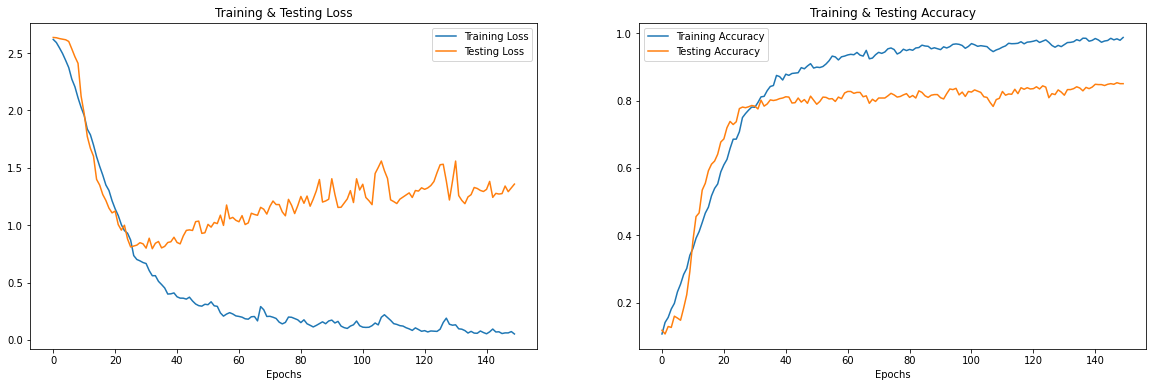

In [54]:
#CNN
epochs = [i for i in range(150)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [55]:
#CNN
pred_test = model.predict(x_testcnn)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

Predicted Labels    Actual Labels
0       female_sad       female_sad
1     male_disgust       male_happy
2  female_surprise  female_surprise
3     female_angry     female_angry
4     female_happy      female_fear
5       female_sad       female_sad
6        male_fear     male_disgust
7         male_sad         male_sad
8  female_surprise  female_surprise
9     male_neutral     male_neutral

# Confusion Matrix Using CNN

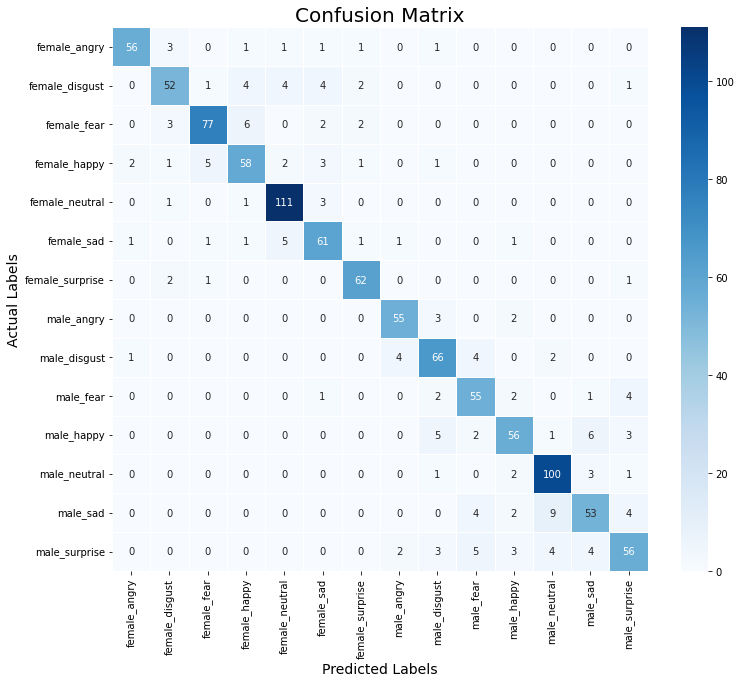

In [56]:
#CNN
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

# Classification Report Using CNN

In [57]:
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

   female_angry       0.93      0.88      0.90        64
 female_disgust       0.84      0.76      0.80        68
    female_fear       0.91      0.86      0.88        90
   female_happy       0.82      0.79      0.81        73
 female_neutral       0.90      0.96      0.93       116
     female_sad       0.81      0.85      0.83        72
female_surprise       0.90      0.94      0.92        66
     male_angry       0.89      0.92      0.90        60
   male_disgust       0.80      0.86      0.83        77
      male_fear       0.79      0.85      0.81        65
     male_happy       0.82      0.77      0.79        73
   male_neutral       0.86      0.93      0.90       107
       male_sad       0.79      0.74      0.76        72
  male_surprise       0.80      0.73      0.76        77

       accuracy                           0.85      1080
      macro avg       0.85      0.84      0.84      1080
   weighted avg       0.85   

**After completing the all training part we got good accuracy using CNN so we plot the confusion matrix and classification report.**

## **SAVING THE MODEL**

In [58]:
model_name = 'model3.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working/saved_models/model3.h5 


In [59]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [60]:
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/kaggle/working/saved_models/model3.h5")
print("Loaded model from disk")

Loaded model from disk


# LIVE DEMO

In [61]:
data, sampling_rate = librosa.load("../input/ravdess-emotional-speech-audio/Actor_01/03-01-02-02-02-01-01.wav")

In [72]:
import os
import pandas as pd
import librosa
import glob 

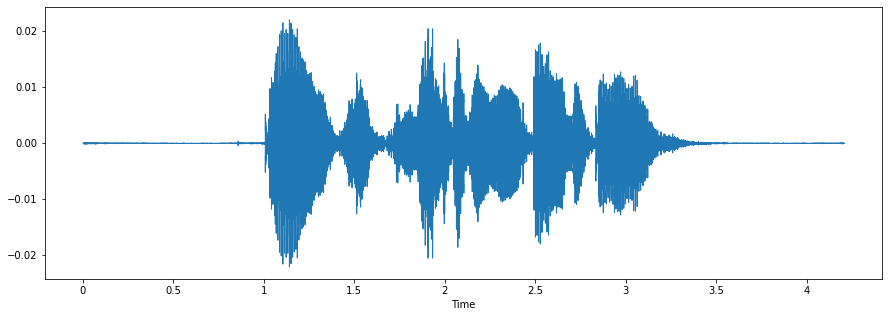

In [64]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [65]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('../input/ravdess-emotional-speech-audio/Actor_08/03-01-01-01-01-01-08.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

In [66]:
livedf2= pd.DataFrame(data=livedf2)
livedf2 = livedf2.stack().to_frame().T
livedf2

0          1          2          3          4          5    \
           0          0          0          0          0          0   
0 -59.083553 -54.093178 -49.728397 -51.274837 -51.939064 -52.804298   

         6         7          8          9    ...        206        207  \
           0         0          0          0  ...          0          0   
0 -54.458553 -52.76355 -52.707867 -50.038662  ... -54.011433 -51.501019   

         208       209        210        211        212        213       214  \
           0         0          0          0          0          0         0   
0 -52.596626 -52.92189 -52.165344 -53.209713 -55.509731 -55.962559 -54.29343   

         215  
           0  
0 -51.896919  

[1 rows x 216 columns]

In [67]:
twodim= np.expand_dims(livedf2, axis=2)

In [68]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 1s 859ms/step


In [69]:
livepreds

array([[5.08484163e-06, 3.21362080e-07, 9.99423742e-01, 5.25841133e-05,
        2.44610474e-05, 3.51394192e-05, 3.42810869e-09, 6.72367696e-06,
        2.03140504e-09, 5.01137492e-07, 9.12453828e-08, 3.44412001e-05,
        4.16860421e-04, 1.09649115e-07]], dtype=float32)

In [70]:
livepreds.shape

(1, 14)

In [71]:
livepredictions = (encoder.inverse_transform((livepreds)))
livepredictions

array([['female_fear']], dtype=object)

# Challenges

  **Large Speech Dataset to Handle**
  
  
  **It is not an easy track to convert Speech to Emotion**
  
  
  **Feelings are subjective, people may interpret them differently. It is difficult to define the concept of emotions**
  